# Image Captioning — BUTD (full pipeline)

Notebook chuẩn: đọc dữ liệu SCAN COCO precomp, build vocab từ COCO, dựng dataloader, định nghĩa model UpDown (BUTD 2-LSTM), huấn luyện XE (OneCycleLR + AdamW + label smoothing), lưu checkpoint, vẽ đồ thị, dự đoán trên validation và đánh giá COCO (Bleu/METEOR/CIDEr/SPICE).

Hãy chạy tuần tự các ô. Các đường dẫn mặc định lấy từ: `/kaggle/input/scan-features/data/data/coco_precomp` và `/kaggle/working/coco`.

Chỉnh `CFG` cell nếu cần.

In [ ]:
# Install (nếu cần)
!pip install -q pycocotools pycocoevalcap
!pip install underthesea transformers sentencepiece
import os
import sys
import json
import re
import time
import random
from pathlib import Path
from collections import Counter, defaultdict
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler

# Thư viện đánh giá và xử lý ngôn ngữ
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from underthesea import word_tokenize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 18.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 72.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.6/978.6 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 100.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from underthesea import word_tokenize
from pathlib import Path
from tqdm import tqdm
import os

# --- 1. CẤU HÌNH ---
SCAN_DIR = Path('/kaggle/input/scan-features/data/data/coco_precomp')
OUT_DIR = Path('/kaggle/working')
PATH_EN_CAPS = SCAN_DIR / 'testall_caps.txt'
PATH_VI_CAPS = OUT_DIR / 'testall_caps_vi.txt'

# Thông số tối ưu P100
BATCH_SIZE = 128  # Tăng mạnh batch size vì dùng FP16
CHECKPOINT_INTERVAL = 100 # Lưu file sau mỗi 100 batch

# --- 2. KHỞI TẠO MÔ HÌNH (Tối ưu FP16) ---
checkpoint = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, src_lang="eng_Latn")

# Load model ở chế độ float16 để chạy cực nhanh trên P100
model = AutoModelForSeq2SeqLM.from_pretrained(
    checkpoint, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True
).to("cuda")

# Lấy ID ngôn ngữ tiếng Việt
forced_bos_token_id = tokenizer.convert_tokens_to_ids("vie_Latn")

def process_batch(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to("cuda")
    
    with torch.no_grad(): # Tắt gradient để tiết kiệm VRAM
        translated_tokens = model.generate(
            **inputs, 
            forced_bos_token_id=forced_bos_token_id, 
            max_length=80,
            num_beams=1,        # Greedy search: Nhanh nhất
            do_sample=False     # Không lấy mẫu ngẫu nhiên để ổn định ngữ nghĩa
        )
    
    decoded = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    
    # Hậu xử lý Underthesea ngay trong batch
    processed_lines = []
    for text in decoded:
        # Nối từ ghép bằng dấu gạch dưới để hỗ trợ Attention
        segmented = word_tokenize(text.lower(), format="underscore")
        processed_lines.append(" ".join(segmented))
    return processed_lines

# --- 3. LUỒNG THỰC THI CHÍNH ---
def main():
    if not PATH_EN_CAPS.exists():
        print("Lỗi: Không tìm thấy file train_caps.txt!")
        return

    with open(PATH_EN_CAPS, 'r', encoding='utf-8') as f:
        en_caps = [line.strip() for line in f]

    # Kiểm tra xem đã có file đang làm dở chưa để chạy tiếp (Resume)
    start_idx = 0
    mode = 'w'
    if PATH_VI_CAPS.exists():
        with open(PATH_VI_CAPS, 'r', encoding='utf-8') as f:
            start_idx = sum(1 for _ in f)
        mode = 'a' # Append nếu đã có dữ liệu
        print(f"Tiếp tục dịch từ câu thứ {start_idx}...")

    print(f"Tổng câu cần xử lý: {len(en_caps)}. Batch size: {BATCH_SIZE}")

    with open(PATH_VI_CAPS, mode, encoding='utf-8') as f_out:
        # Tqdm hiển thị tiến trình
        for i in tqdm(range(start_idx, len(en_caps), BATCH_SIZE)):
            batch = en_caps[i : i + BATCH_SIZE]
            
            try:
                vi_results = process_batch(batch)
                for line in vi_results:
                    f_out.write(line + "\n")
                
                # Giải phóng bộ nhớ đệm GPU định kỳ
                if (i // BATCH_SIZE) % CHECKPOINT_INTERVAL == 0:
                    f_out.flush() # Đẩy dữ liệu xuống ổ đĩa
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"\nLỗi nghiêm trọng tại dòng {i}: {e}")
                # Giữ chỗ để không lệch ID
                for _ in range(len(batch)):
                    f_out.write("loi_dich_thuat\n")

    print(f"\n--- HOÀN TẤT ---")
    print(f"File kết quả: {PATH_VI_CAPS}")

if __name__ == "__main__":
    main()

In [ ]:
# ---------------- CONFIG (Khởi tạo hệ thống) ----------------
# 1. Quản lý đường dẫn (Path management)
ROOT_SCAN    = Path('/kaggle/input/scan-features/data/data/coco_precomp')
SCAN_DIR     = ROOT_SCAN
VI_CAPS_DIR  = Path('/kaggle/input/captions-vi')
OUT_DIR      = Path('/kaggle/working')

# Tạo thư mục đầu ra
OUT_DIR.mkdir(parents=True, exist_ok=True)
COCO_OUT = OUT_DIR / 'coco'
COCO_OUT.mkdir(parents=True, exist_ok=True)

# 2. File dữ liệu cụ thể
PATH_EN_CAPS   = SCAN_DIR / 'train_caps.txt'
PATH_VI_CAPS   = VI_CAPS_DIR / 'train_caps_vi.txt'
VOCAB_FILE     = VI_CAPS_DIR / 'train_caps_vi.txt'
VAL_JSON       = OUT_DIR / "coco_json/captions_val2014.json"
SAVE_PATH_JSON = OUT_DIR / "vocab_butd.json"

# 3. Cấu hình phần cứng & Tái lập (Reproducibility)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 4. Tham số Huấn luyện (Training Config)
MAXLEN       = 30
EPOCHS       = 10      # Epochs cho giai đoạn đầu (CE)
FT_EPOCHS    = 10      # Epochs cho giai đoạn Fine-tuning (SCST)
BATCH_TRAIN  = 128     # Batch size huấn luyện CE
BATCH_IMG    = 128     # Batch size xử lý ảnh
BATCH_SCST   = 48      # Batch size huấn luyện SCST (thấp hơn vì tốn RAM)
WORKERS      = 4
PIN_MEMORY   = False   # Để False nếu RAM hệ thống thấp

# 5. Tham số Tối ưu hóa (Optimization)
FT_LR           = 1e-4
WEIGHT_DECAY    = 1e-5
ONECYCLE_MAX_LR = 3e-4
N_EVAL          = 1    # Chu kỳ đánh giá (mỗi N epoch)

print(f'✅ Cấu hình hoàn tất!')
print(f'   - Dữ liệu gốc: {SCAN_DIR}')
print(f'   - Dữ liệu Tiếng Việt: {PATH_VI_CAPS}')
print(f'   - Thiết bị sử dụng: {DEVICE}')

SCAN_DIR /kaggle/input/scan-features/data/data/coco_precomp


In [ ]:

def verify_mapping(n_samples=10):
    if not PATH_VI_CAPS.exists():
        print(f"Lỗi: Không tìm thấy file Tiếng Việt tại {PATH_VI_CAPS}")
        return

    # 1. Đọc nội dung cả hai file
    with open(PATH_EN_CAPS, 'r', encoding='utf-8') as f:
        en_lines = [line.strip() for line in f]
    
    with open(PATH_VI_CAPS, 'r', encoding='utf-8') as f:
        vi_lines = [line.strip() for line in f]

    # 2. Kiểm tra độ dài
    print(f"--- KIỂM TRA ĐỘ DÀI ---")
    print(f"Số lượng câu Tiếng Anh: {len(en_lines)}")
    print(f"Số lượng câu Tiếng Việt: {len(vi_lines)}")
    
    if len(en_lines) != len(vi_lines):
        print("⚠️ CẢNH BÁO: Số lượng dòng không khớp! Mapping có thể bị lệch.")
    else:
        print("✅ Độ dài khớp nhau hoàn toàn.")
    print("-" * 50)

    # 3. Lấy mẫu ngẫu nhiên để so sánh
    print(f"--- SO SÁNH NGẪU NHIÊN {n_samples} CẶP CÂU ---")
    total = min(len(en_lines), len(vi_lines))
    indices = random.sample(range(total), n_samples)

    for i, idx in enumerate(indices):
        # Tính toán Image Index (vì 5 câu ứng với 1 ảnh)
        img_idx = idx // 5 
        print(f"Mẫu {i+1} [Dòng: {idx} | Thuộc ảnh thứ: {img_idx}]")
        print(f"  [EN]: {en_lines[idx]}")
        print(f"  [VI]: {vi_lines[idx]}")
        print("-" * 30)

# Chạy kiểm chứng
verify_mapping(n_samples=5)

--- KIỂM TRA ĐỘ DÀI ---
Số lượng câu Tiếng Anh: 566435
Số lượng câu Tiếng Việt: 566435
✅ Độ dài khớp nhau hoàn toàn.
--------------------------------------------------
--- SO SÁNH NGẪU NHIÊN 5 CẶP CÂU ---
Mẫu 1 [Dòng: 116739 | Thuộc ảnh thứ: 23347]
  [EN]: a woman holding a wil controller with a steering wheel
  [VI]: một người phụ nữ cầm một bộ điều khiển quét với bánh lái
------------------------------
Mẫu 2 [Dòng: 26225 | Thuộc ảnh thứ: 5245]
  [EN]: A man riding a motorcycle down a street next to a restaurant .
  [VI]: một người đàn ông đang đi xe máy xuống đường bên cạnh một nhà hàng .
------------------------------
Mẫu 3 [Dòng: 288389 | Thuộc ảnh thứ: 57677]
  [EN]: A street sign on the city streets of Houston and Luldlow .
  [VI]: một biển hiệu trên đường phố houston và luldlow .
------------------------------
Mẫu 4 [Dòng: 256787 | Thuộc ảnh thứ: 51357]
  [EN]: A large blue and white airplane on an airport runway .
  [VI]: một chiếc máy bay lớn màu xanh và trắng trên đường băng 

In [ ]:

def read_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

print("📂 Đang nạp dữ liệu thô...")

train_ids_raw = read_lines(SCAN_DIR / 'train_ids.txt')
dev_ids_raw   = read_lines(SCAN_DIR / 'testall_ids.txt')
test_ids_raw  = read_lines(SCAN_DIR / 'test_ids.txt')

train_caps_vi = read_lines(VI_CAPS_DIR / 'train_caps_vi.txt')
dev_caps_vi   = read_lines(VI_CAPS_DIR / 'testall_caps_vi.txt')
test_caps_vi  = read_lines(VI_CAPS_DIR / 'test_caps_vi.txt')

def align_caps_and_ids(caps, ids_raw):
    if len(ids_raw) * 5 == len(caps):
        return np.repeat(ids_raw, 5).tolist()
    return ids_raw

train_cap2img = align_caps_and_ids(train_caps_vi, train_ids_raw)
dev_cap2img   = align_caps_and_ids(dev_caps_vi, dev_ids_raw)
test_cap2img  = align_caps_and_ids(test_caps_vi, test_ids_raw)
def build_coco_json(split_name, caps, ids, out_dir):
    uniq_idx = list(dict.fromkeys(ids))
    idx2imgid = {idx: i + 1 for i, idx in enumerate(uniq_idx)}
    images = [
        {
            "id": idx2imgid[idx], 
            "file_name": f"{idx}.jpg", 
            "height": 0, 
            "width": 0
        } for idx in uniq_idx
    ]
    anns = []
    for aid, (c, idx) in enumerate(zip(caps, ids), 1):
        caption_clean = c.split(maxsplit=1)[-1] if '#' in c else c
        
        anns.append({
            "id": aid, 
            "image_id": idx2imgid[idx], 
            "caption": caption_clean
        })
    fname = {
        'train': 'captions_train2014.json',
        'dev': 'captions_val2014.json',
        'test': 'captions_test2014.json'
    }[split_name]
    
    out_path = out_dir / fname
    
    with open(out_path, 'w', encoding='utf-8') as f:
        json.dump({
            "images": images, 
            "annotations": anns, 
            "type": "captions", 
            "licenses": [], 
            "info": {}
        }, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Đã ghi: {out_path} | Images: {len(images)} | Anns: {len(anns)}")
    return out_path

print("\n🛠 Đang khởi tạo các file JSON COCO...")

if not (COCO_OUT / 'captions_train2014.json').exists():
    build_coco_json('train', train_caps_vi, train_cap2img, COCO_OUT)

if not (COCO_OUT / 'captions_val2014.json').exists():
    VAL_JSON = build_coco_json('dev', dev_caps_vi, dev_cap2img, COCO_OUT)
else:
    VAL_JSON = COCO_OUT / 'captions_val2014.json'

if not (COCO_OUT / 'captions_test2014.json').exists():
    TEST_JSON = build_coco_json('test', test_caps_vi, test_cap2img, COCO_OUT)
else:
    TEST_JSON = COCO_OUT / 'captions_test2014.json'

print(f"\n🚀 Hoàn tất! Biến VAL_JSON hiện đang trỏ tới: {VAL_JSON}")

📂 Đang nạp dữ liệu thô...

🛠 Đang khởi tạo các file JSON COCO...

🚀 Hoàn tất! Biến VAL_JSON hiện đang trỏ tới: /kaggle/working/coco_json/captions_val2014.json


In [ ]:

SPECIAL_TOKENS = {
    "pad": "<pad>",
    "bos": "<s>",
    "eos": "</s>",
    "unk": "<unk>"
}

def build_and_save_json_vocab(file_path, save_path, min_freq=1):
    print(f"--- Đang build vocab từ: {file_path} ---")
    counter = Counter()
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            caption = parts[1].lower() if len(parts) > 1 else parts[0].lower()
            tokens = caption.split()
            counter.update(tokens)

    itos = [SPECIAL_TOKENS["pad"], SPECIAL_TOKENS["bos"], 
            SPECIAL_TOKENS["eos"], SPECIAL_TOKENS["unk"]]
    
    added_words = [word for word, count in counter.most_common() if count >= min_freq]
    itos.extend(added_words)
    stoi = {word: i for i, word in enumerate(itos)}
    vocab_dict = {
        "info": {
            "min_freq": min_freq,
            "vocab_size": len(itos),
            "total_tokens_found": sum(counter.values())
        },
        "itos": itos,
        "stoi": stoi
    }
    with open(save_path, 'w', encoding='utf-8') as f:
        json.dump(vocab_dict, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Đã lưu JSON tại: {save_path}")
    print(f"Kích thước Vocab mới: {len(itos)} từ (với min_freq={min_freq})")
    return itos, stoi
itos, stoi = build_and_save_json_vocab(VOCAB_FILE, SAVE_PATH_JSON, min_freq=1)

PAD = stoi[SPECIAL_TOKENS["pad"]]
BOS = stoi[SPECIAL_TOKENS["bos"]]
EOS = stoi[SPECIAL_TOKENS["eos"]]
UNK = stoi[SPECIAL_TOKENS["unk"]]
VOCAB_SIZE = len(itos)
print(f"10 từ phổ biến nhất: {itos[4:14]}")


--- Đang build vocab từ: /kaggle/input/captions-vi/train_caps_vi.txt ---
✅ Đã lưu JSON tại: /kaggle/working/vocab_butd.json
Kích thước Vocab mới: 9158 từ (với min_freq=1)
10 từ phổ biến nhất: ['.', 'một', 'trên', 'người', 'con', 'và', 'đang', 'với', 'trong', 'chiếc']


In [ ]:

# --- BƯỚC 2: HÀM ĐỌC DỮ LIỆU ---
def read_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

print("Đang nạp dữ liệu từ các file...")

# Nạp ID ảnh
train_ids = read_lines(SCAN_DIR / 'train_ids.txt')
dev_ids = read_lines(SCAN_DIR / 'testall_ids.txt')
test_ids = read_lines(SCAN_DIR / 'test_ids.txt')

# Nạp Captions Tiếng Việt (Tự động loại bỏ prefix ID nếu có)
train_caps_raw = read_lines(VI_CAPS_DIR / 'train_caps_vi.txt')
train_caps_vi = [c.split(maxsplit=1)[-1] if '#' in c else c for c in train_caps_raw]

# Nạp đặc trưng ảnh (mmap_mode='r' để tiết kiệm RAM)
train_ims = np.load(SCAN_DIR / 'train_ims.npy', mmap_mode='r')
dev_ims = np.load(SCAN_DIR / 'testall_ims.npy', mmap_mode='r')
test_ims = np.load(SCAN_DIR / 'test_ims.npy', mmap_mode='r')

print(f"Nạp xong! Train: {len(train_caps_vi)} câu | Val IDs: {len(dev_ids)}")

# --- BƯỚC 3: LOGIC MAPPING CHUẨN ---
order_train = train_ids if len(train_ids) == train_ims.shape[0] else sorted(set(train_ids))
old2row = {old: i for i, old in enumerate(order_train)}

if len(train_ids) * 5 == len(train_caps_vi):
    cap2img_old = np.repeat(train_ids, 5).tolist()
else:
    cap2img_old = np.repeat(sorted(set(train_ids)), 5).tolist()[:len(train_caps_vi)]

cap2row = np.fromiter((old2row[o] for o in cap2img_old), dtype=np.int64, count=len(cap2img_old))

# --- BƯỚC 4: ĐỊNH NGHĨA DATASETS & COLLATE ---
class ScanTrainCapAligned(Dataset):
    def __init__(self, X_mmap, caps, cap2row):
        self.X = X_mmap      # Đây là biến chứa features (train_ims)
        self.caps = caps
        self.cap2row = cap2row
        
    def __len__(self): 
        return len(self.caps)
    
    def __getitem__(self, i):
        # Lấy chỉ số hàng thực tế trong file features dựa trên index của câu
        row_idx = self.cap2row[i]
        
        # SỬA TẠI ĐÂY: Dùng self.X thay vì self.images
        x = self.X[row_idx]
        
        # .copy() để tránh lỗi non-writable array khi dùng mmap
        x_writable = x.copy()
        
        # Trả về feature và câu caption (collate_fn sẽ tokenize sau)
        return torch.from_numpy(x_writable), self.caps[i]

class ImgOnlyDataset(Dataset):
    def __init__(self, X_mmap, cap_level_ids):
        first = {}
        for r, iid in enumerate(cap_level_ids):
            if iid not in first: first[iid] = r
        uniq = sorted(first.keys())
        self.rows = [first[i] for i in uniq]
        self.img_ids = [i for i in uniq]
        self.X = X_mmap
    def __len__(self): return len(self.rows)
    def __getitem__(self, i):
        x = np.asarray(self.X[self.rows[i]], dtype=np.float32)
        return torch.from_numpy(x), int(self.img_ids[i])

@dataclass
class CollateBUTD:
    stoi: dict
    bos_id: int
    eos_id: int
    unk_id: int
    pad_id: int
    max_len: int = 50

    def __call__(self, batch):
        feats, caps = zip(*batch)
        feats = torch.stack(feats)
        
        seqs = []
        for c in caps:
            tokens = c.lower().split()
            ids = [self.bos_id] + [self.stoi.get(t, self.unk_id) for t in tokens][:self.max_len-2] + [self.eos_id]
            seqs.append(torch.tensor(ids, dtype=torch.long))
        
        padded_ids = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True, padding_value=self.pad_id)
        lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
        
        return feats, padded_ids, lengths

# --- BƯỚC 5: KHỞI TẠO DATALOADERS ---

# 1. Khởi tạo Datasets
train_ds = ScanTrainCapAligned(train_ims, train_caps_vi, cap2row)
val_img_ds = ImgOnlyDataset(dev_ims, dev_ids)
test_img_ds = ImgOnlyDataset(test_ims, test_ids)

# 2. Khởi tạo Collate với đầy đủ các ID từ cell Build Vocab
# Đảm bảo bạn đã chạy cell build vocab để có các biến BOS, EOS, UNK, PAD
collate_train = CollateBUTD(
    stoi=stoi, 
    bos_id=BOS, 
    eos_id=EOS, 
    unk_id=UNK, 
    pad_id=PAD, 
    max_len=MAXLEN
)

# 3. Khởi tạo DataLoaders
train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_TRAIN, 
    shuffle=True, 
    num_workers=WORKERS, 
    pin_memory=PIN_MEMORY, 
    collate_fn=collate_train
)

val_img_dl = DataLoader(
    val_img_ds, 
    batch_size=BATCH_IMG, 
    shuffle=False, 
    num_workers=WORKERS, 
    pin_memory=PIN_MEMORY, 
    collate_fn=lambda b: (torch.stack([x[0] for x in b]), torch.tensor([x[1] for x in b], dtype=torch.long))
)

print('✅ Hoàn tất khởi tạo DataLoaders cho kiến trúc BUTD.')
print(f'Số lượng từ điển: {len(stoi)} | Số lượng batch huấn luyện: {len(train_dl)}')

Đang nạp dữ liệu từ các file...
Nạp xong! Train: 566435 câu | Val IDs: 25000
✅ Hoàn tất khởi tạo DataLoaders cho kiến trúc BUTD.
Số lượng từ điển: 9158 | Số lượng batch huấn luyện: 4426


In [ ]:


class UpDownDecoder(nn.Module):
    def __init__(self, vocab_size, emb=256, hid=512, feat_dim=2048, pad_idx=0, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hid = hid
        self.pad_idx = pad_idx
        
        # Lớp Embedding tự học
        self.emb = nn.Embedding(vocab_size, emb, padding_idx=pad_idx)
        
        # Chiếu đặc trưng ảnh SCAN
        self.feat_proj = nn.Linear(feat_dim, hid)
        self.feat_ln = nn.LayerNorm(hid)
        
        # 2 lớp LSTM chuẩn BUTD
        # Attention LSTM nhận: [word_emb + global_img_feat + prev_lang_h]
        self.att_lstm = nn.LSTMCell(emb + hid + hid, hid)
        # Language LSTM nhận: [attended_img_feat + current_att_h]
        self.lang_lstm = nn.LSTMCell(hid + hid, hid)
        
        # Các lớp Linear cho Attention
        self.att_v = nn.Linear(hid, hid)
        self.att_h = nn.Linear(hid, hid)
        self.att_u = nn.Linear(hid, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hid, vocab_size)
        
        self._init_weights()

    def _init_weights(self):
        """Khởi tạo trọng số để mô hình hội tụ nhanh hơn"""
        nn.init.xavier_uniform_(self.feat_proj.weight)
        nn.init.xavier_uniform_(self.out.weight)
        self.emb.weight.data.normal_(0, 0.02)

    def _attend(self, f, h_att):
        B, R, H = f.size()
        h = self.att_h(h_att).unsqueeze(1).expand(B, R, H)
        e = self.att_u(torch.tanh(self.att_v(f) + h)).squeeze(-1)
        alpha = torch.softmax(e, dim=-1)
        v_hat = torch.bmm(alpha.unsqueeze(1), f).squeeze(1)
        return v_hat, alpha

    def forward(self, feats, caps):
        """
        Dùng cho Training XE.
        feats: [B, 36, 2048]
        caps: [B, T] (Thường là input sequence đã bỏ token cuối)
        """
        B, R, _ = feats.shape
        T = caps.size(1)
        
        f = self.feat_ln(self.feat_proj(feats))
        f_mean = f.mean(1)
        
        h_att = feats.new_zeros(B, self.hid); c_att = feats.new_zeros(B, self.hid)
        h_lang = feats.new_zeros(B, self.hid); c_lang = feats.new_zeros(B, self.hid)
        
        logits = []
        for t in range(T):
            w_t = self.emb(caps[:, t])
            # Attention LSTM
            h_att, c_att = self.att_lstm(torch.cat([w_t, f_mean, h_lang], -1), (h_att, c_att))
            # Attention Mechanism
            v_hat, _ = self._attend(f, h_att)
            # Language LSTM
            h_lang, c_lang = self.lang_lstm(torch.cat([v_hat, h_att], -1), (h_lang, c_lang))
            
            logits.append(self.out(self.dropout(h_lang)))
            
        return torch.stack(logits, 1)
    @torch.no_grad()
    def beam_search(self, feats, beam_size=5, max_len=30, bos=1, eos=2, pad=0, 
                    length_penalty=0.6, no_repeat_ngram_size=2):
        device = feats.device
        B, R, _ = feats.shape
        f = self.feat_ln(self.feat_proj(feats))
        f_mean = f.mean(1).repeat_interleave(beam_size, dim=0)
        f = f.repeat_interleave(beam_size, dim=0)

        hA = feats.new_zeros(B * beam_size, self.hid)
        cA = feats.new_zeros(B * beam_size, self.hid)
        hL = feats.new_zeros(B * beam_size, self.hid)
        cL = feats.new_zeros(B * beam_size, self.hid)

        beams = torch.full((B, beam_size, 1), bos, dtype=torch.long, device=device)
        scores = torch.zeros(B, beam_size, device=device)
        scores[:, 1:] = -1e9 
        
        finished_sentences = [[] for _ in range(B)]

        for t in range(max_len):
            prev_tokens = beams[:, :, -1].reshape(-1)
            w_t = self.emb(prev_tokens)

            hA, cA = self.att_lstm(torch.cat([w_t, f_mean, hL], -1), (hA, cA))
            v_hat, _ = self._attend(f, hA)
            hL, cL = self.lang_lstm(torch.cat([v_hat, hA], -1), (hL, cL))
            
            log_probs = F.log_softmax(self.out(hL), dim=-1).view(B, beam_size, -1)
            
            # --- 1. No Repeat N-gram Blocking ---
            if no_repeat_ngram_size > 0 and t >= no_repeat_ngram_size - 1:
                for b in range(B):
                    for k in range(beam_size):
                        # Lấy n-1 tokens gần nhất
                        ngram = beams[b, k, -(no_repeat_ngram_size-1):].tolist()
                        # Tìm trong lịch sử xem ngram này đã xuất hiện chưa
                        history = beams[b, k].tolist()
                        for i in range(len(history) - no_repeat_ngram_size + 1):
                            if history[i:i+no_repeat_ngram_size-1] == ngram:
                                forbidden_word = history[i+no_repeat_ngram_size-1]
                                log_probs[b, k, forbidden_word] = -1e9

            curr_scores = scores.unsqueeze(-1) + log_probs
            topk_scores, topk_indices = torch.topk(curr_scores.view(B, -1), beam_size, dim=-1)
            
            next_beam_idx = topk_indices // self.vocab_size 
            next_tokens = topk_indices % self.vocab_size    
            
            new_beams = []
            tmp_hA, tmp_cA = hA.view(B, beam_size, -1), cA.view(B, beam_size, -1)
            tmp_hL, tmp_cL = hL.view(B, beam_size, -1), cL.view(B, beam_size, -1)
            
            new_hA, new_cA, new_hL, new_cL = [], [], [], []

            for b in range(B):
                idx = next_beam_idx[b]
                new_beams.append(torch.cat([beams[b][idx], next_tokens[b].unsqueeze(-1)], dim=-1))
                new_hA.append(tmp_hA[b][idx]); new_cA.append(tmp_cA[b][idx])
                new_hL.append(tmp_hL[b][idx]); new_cL.append(tmp_cL[b][idx])
            
            beams = torch.stack(new_beams)
            scores = topk_scores
            hA, cA = torch.stack(new_hA).view(B*beam_size, -1), torch.stack(new_cA).view(B*beam_size, -1)
            hL, cL = torch.stack(new_hL).view(B*beam_size, -1), torch.stack(new_cL).view(B*beam_size, -1)

            for b in range(B):
                for k in range(beam_size):
                    if beams[b, k, -1] == eos:
                        # --- 2. Length Penalty ---
                        # Formula: score = log_prob / (length ^ lp)
                        seq_len = beams[b, k].size(0) - 1 # trừ BOS
                        lp = ((5.0 + seq_len) / 6.0) ** length_penalty
                        norm_score = scores[b, k].item() / lp
                        
                        if len(finished_sentences[b]) < beam_size:
                            finished_sentences[b].append((norm_score, beams[b, k, 1:].clone()))
                        scores[b, k] -= 1e9 

        final_outs = []
        for b in range(B):
            if finished_sentences[b]:
                best_seq = max(finished_sentences[b], key=lambda x: x[0])[1]
            else:
                best_seq = beams[b, 0, 1:]
            final_outs.append(best_seq)
            
        max_l = max(len(x) for x in final_outs)
        res = torch.full((B, max_l), pad, dtype=torch.long, device=device)
        for i, seq in enumerate(final_outs):
            res[i, :len(seq)] = seq
        return res

# Khởi tạo model
model = UpDownDecoder(
    vocab_size=len(itos), 
    emb=256, 
    hid=512, 
    feat_dim=2048, 
    pad_idx=PAD
).to(DEVICE)

print(f"✅ Model BUTD Ready! Vocab size: {len(itos)}")

✅ Model BUTD Ready! Vocab size: 9158


In [54]:
import json
import torch
import re
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

# --- BƯỚC 1: HÀM GIẢI MÃ (DECODE) VÀ LÀM ĐẸP VĂN BẢN ---
def detok_vietnamese(s: str) -> str:
    """Xử lý hậu kỳ: bỏ gạch dưới, viết hoa đầu câu, thêm dấu chấm"""
    s = s.strip()
    # Chuyển "xe_đạp" -> "xe đạp"
    s = s.replace("_", " ")
    # Xóa khoảng trắng thừa quanh dấu câu
    s = re.sub(r"\s+([,.;:!?])", r"\1", s)
    s = re.sub(r"\s{2,}", " ", s)
    # Viết hoa đầu dòng
    if s: 
        s = s[0].upper() + s[1:]
    # Thêm dấu chấm cuối câu nếu thiếu
    if s and s[-1] not in '.!?': 
        s = s + '.'
    return s

def decode_min(seq):
    """Chuyển list ID thành chuỗi dựa trên itos của Vocab tự build"""
    if torch.is_tensor(seq):
        seq = seq.tolist()
    
    words = []
    for tid in seq:
        if tid == BOS: continue # Bỏ qua <s>
        if tid == EOS: break    # Dừng khi gặp </s>
        if tid == PAD: continue # Bỏ qua <pad>
        
        word = itos[tid] if 0 <= tid < len(itos) else "<unk>"
        words.append(word)
    return " ".join(words).strip()

def decode_for_eval(seq):
    """Pipeline giải mã hoàn chỉnh cho đánh giá"""
    s = decode_min(seq)
    if not s: return "."
    return detok_vietnamese(s)

# --- BƯỚC 2: WRAPPER GỌI BEAM SEARCH ---
def _call_beam_search(feats, beam, max_len, lp=0.7, ngram=2):
    """
    lp (Length Penalty): 0.6 - 1.0 (tăng nếu muốn câu dài hơn)
    ngram (No-repeat size): 2 hoặc 3 (tránh lặp từ)
    """
    # model.beam_search cần được định nghĩa trong class UpDownDecoder hoặc Transformer
    return model.beam_search(
        feats=feats,
        beam_size=beam,
        max_len=max_len,
        bos=BOS,
        eos=EOS,
        pad=PAD,
        length_penalty=lp,
        no_repeat_ngram_size=ngram
    )

def _old2coco_from_ann(ann_path):
    """
    Ánh xạ chuẩn: ID gốc (ví dụ 458755) -> ID trong JSON (ví dụ 123)
    """
    with open(ann_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # images trong JSON của bạn có 'file_name' chứa ID gốc (ví dụ "458755.jpg")
    # Chúng ta tách lấy ID gốc đó để làm Key
    img_map = {}
    for img in data['images']:
        # Lấy ID gốc từ file_name (bỏ đuôi .jpg)
        original_id_str = img['file_name'].split('.')[0]
        try:
            # Chuyển về int để khớp với ids từ DataLoader
            original_id = int(original_id_str)
        except:
            original_id = original_id_str
            
        img_map[original_id] = img['id']
        
    return img_map

def predict_from_loader(img_loader, json_out, beam=5, max_len=30, lp=0.7, ngram=2):
    out = []
    model.eval()
    
    # Lấy mapping từ file JSON bạn đã build (VAL_JSON)
    _map = _old2coco_from_ann(VAL_JSON)
    
    with torch.no_grad():
        for feats, ids in tqdm(img_loader, desc=f'Predicting'):
            feats = feats.to(DEVICE)
            hyps = _call_beam_search(feats, beam, max_len, lp, ngram)
            hyps = hyps.cpu()

            for i in range(hyps.size(0)):
                # idx là số thứ tự dòng (0, 1, 2...)
                idx = int(ids[i])
                
                # ÉP BUỘC dùng ID từ map (ví dụ: chuyển 458755 thành 123)
                if idx in _map:
                    coco_id = _map[idx]
                    caption = decode_for_eval(hyps[i])
                    out.append({'image_id': int(coco_id), 'caption': caption})
                else:
                    # Nếu ids[i] vốn đã là index 0-4999 thì dùng luôn
                    out.append({'image_id': idx + 1, 'caption': decode_for_eval(hyps[i])})

    with open(json_out, 'w', encoding='utf-8') as f:
        json.dump(out, f, ensure_ascii=False, indent=4)
    return json_out

# --- BƯỚC 4: HÀM ĐÁNH GIÁ METRICS COCO ---
def coco_eval(ann_json, res_json, title='VALIDATION'):
    """Tính toán Bleu, METEOR, ROUGE_L, CIDEr"""
    # Khởi tạo đối tượng COCO cho ground-truth
    coco = COCO(str(ann_json))
    # Nạp kết quả dự đoán của model
    cocoRes = coco.loadRes(str(res_json))
    
    cocoEval = COCOEvalCap(coco, cocoRes)
    cocoEval.params['image_id'] = cocoRes.getImgIds()
    
    print(f"--- Đang tính toán các chỉ số Metric cho {title} ---")
    cocoEval.evaluate()
    
    print(f'\n[ KẾT QUẢ ĐÁNH GIÁ: {title} ]')
    print("-" * 40)
    
    # Các chỉ số quan trọng cần theo dõi
    metrics_to_show = ['Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr']
    final_metrics = {}
    for metric, score in cocoEval.eval.items():
        if metric in metrics_to_show:
            print(f"{metric:>10}: {score:.4f}")
        final_metrics[metric] = score
        
    print("-" * 40)
    return final_metrics

print("✅ Hệ thống Prediction & Evaluation đã đồng bộ với file JSON mới!")

✅ Hệ thống Prediction & Evaluation đã đồng bộ với file JSON mới!


BUTD Train ep1/10: 100%|██████████| 4426/4426 [10:49<00:00,  6.82it/s, loss=3.9570, lr=0.000084]


Epoch 1 | Train Loss: 3.9570
--- Đang đánh giá tại Epoch 1 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 1 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 667196.92 tokens per second.
PTBTokenizer tokenized 57159 tokens at 311589.85 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 47160, 'reflen': 50166, 'guess': [47160, 42160, 37160, 32160], 'correct': [36877, 22547, 12991, 6709]}
ratio: 0.9400789379260667
Bleu_1: 0.734
Bleu_2: 0.607
Bleu_3: 0.494
Bleu_4: 0.392
computing METEOR score...
METEOR: 0.342
computing Rouge score...
ROUGE_L: 0.562
computing CIDEr score...
CIDEr: 1.169
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.6 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.2 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 1.134 min
SPICE: 0.091

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 1 Validation ]
----------------------------------------
    Bleu_4: 0.3921
    METEOR: 0.3423
   ROUGE_L: 0.5616
     CIDEr: 1.1689
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.1689


BUTD Train ep2/10: 100%|██████████| 4426/4426 [10:48<00:00,  6.82it/s, loss=3.4763, lr=0.000228]


Epoch 2 | Train Loss: 3.4763
--- Đang đánh giá tại Epoch 2 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.33s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 2 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 670467.32 tokens per second.
PTBTokenizer tokenized 59538 tokens at 282740.53 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 49537, 'reflen': 51431, 'guess': [49537, 44537, 39537, 34537], 'correct': [38967, 25036, 15287, 8441]}
ratio: 0.96317396122959
Bleu_1: 0.757
Bleu_2: 0.640
Bleu_3: 0.534
Bleu_4: 0.435
computing METEOR score...
METEOR: 0.357
computing Rouge score...
ROUGE_L: 0.584
computing CIDEr score...
CIDEr: 1.313
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 1.294 min
SPICE: 0.102

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 2 Validation ]
----------------------------------------
    Bleu_4: 0.4352
    METEOR: 0.3571
   ROUGE_L: 0.5838
     CIDEr: 1.3133
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.3133


BUTD Train ep3/10: 100%|██████████| 4426/4426 [10:53<00:00,  6.78it/s, loss=3.1710, lr=0.000300]


Epoch 3 | Train Loss: 3.1710
--- Đang đánh giá tại Epoch 3 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 3 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 757667.89 tokens per second.
PTBTokenizer tokenized 61463 tokens at 320475.02 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 51459, 'reflen': 52715, 'guess': [51459, 46459, 41459, 36459], 'correct': [40473, 26117, 16181, 9175]}
ratio: 0.9761737645831172
Bleu_1: 0.768
Bleu_2: 0.649
Bleu_3: 0.543
Bleu_4: 0.445
computing METEOR score...
METEOR: 0.364
computing Rouge score...
ROUGE_L: 0.593
computing CIDEr score...
CIDEr: 1.376
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8

SPICE evaluation took: 1.060 min
SPICE: 0.107

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 3 Validation ]
----------------------------------------
    Bleu_4: 0.4455
    METEOR: 0.3644
   ROUGE_L: 0.5929
     CIDEr: 1.3756
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.3756


BUTD Train ep4/10: 100%|██████████| 4426/4426 [10:51<00:00,  6.80it/s, loss=3.0299, lr=0.000285]


Epoch 4 | Train Loss: 3.0299
--- Đang đánh giá tại Epoch 4 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 4 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 603338.32 tokens per second.
PTBTokenizer tokenized 60621 tokens at 312850.16 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 50592, 'reflen': 52210, 'guess': [50592, 45592, 40592, 35592], 'correct': [39938, 25940, 16129, 9148]}
ratio: 0.969009768243613
Bleu_1: 0.765
Bleu_2: 0.649
Bleu_3: 0.545
Bleu_4: 0.448
computing METEOR score...
METEOR: 0.364
computing Rouge score...
ROUGE_L: 0.595
computing CIDEr score...
CIDEr: 1.385
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8

SPICE evaluation took: 54.23 s
SPICE: 0.105

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 4 Validation ]
----------------------------------------
    Bleu_4: 0.4482
    METEOR: 0.3638
   ROUGE_L: 0.5950
     CIDEr: 1.3851
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.3851


BUTD Train ep5/10: 100%|██████████| 4426/4426 [10:54<00:00,  6.77it/s, loss=2.9490, lr=0.000244]


Epoch 5 | Train Loss: 2.9490
--- Đang đánh giá tại Epoch 5 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 5 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 576034.65 tokens per second.
PTBTokenizer tokenized 62260 tokens at 266666.79 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 52196, 'reflen': 53291, 'guess': [52196, 47196, 42196, 37196], 'correct': [41193, 26838, 16829, 9757]}
ratio: 0.9794524403745289
Bleu_1: 0.773
Bleu_2: 0.656
Bleu_3: 0.552
Bleu_4: 0.456
computing METEOR score...
METEOR: 0.370
computing Rouge score...
ROUGE_L: 0.600
computing CIDEr score...
CIDEr: 1.418
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.2 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8

SPICE evaluation took: 57.94 s
SPICE: 0.108

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 5 Validation ]
----------------------------------------
    Bleu_4: 0.4558
    METEOR: 0.3702
   ROUGE_L: 0.5998
     CIDEr: 1.4177
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.4177


BUTD Train ep6/10: 100%|██████████| 4426/4426 [10:56<00:00,  6.74it/s, loss=2.8908, lr=0.000183]


Epoch 6 | Train Loss: 2.8908
--- Đang đánh giá tại Epoch 6 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 6 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 708085.75 tokens per second.
PTBTokenizer tokenized 61414 tokens at 267984.90 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 51350, 'reflen': 52730, 'guess': [51350, 46350, 41350, 36350], 'correct': [40649, 26626, 16759, 9766]}
ratio: 0.9738289398824015
Bleu_1: 0.771
Bleu_2: 0.656
Bleu_3: 0.554
Bleu_4: 0.459
computing METEOR score...
METEOR: 0.369
computing Rouge score...
ROUGE_L: 0.602
computing CIDEr score...
CIDEr: 1.421
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.2 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8

SPICE evaluation took: 50.03 s
SPICE: 0.108

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 6 Validation ]
----------------------------------------
    Bleu_4: 0.4592
    METEOR: 0.3685
   ROUGE_L: 0.6017
     CIDEr: 1.4207
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.4207


BUTD Train ep7/10: 100%|██████████| 4426/4426 [10:54<00:00,  6.76it/s, loss=2.8445, lr=0.000117]


Epoch 7 | Train Loss: 2.8445
--- Đang đánh giá tại Epoch 7 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 7 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 715228.44 tokens per second.
PTBTokenizer tokenized 62600 tokens at 320653.56 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 52541, 'reflen': 53439, 'guess': [52541, 47541, 42541, 37541], 'correct': [41643, 27406, 17319, 10127]}
ratio: 0.9831957933344377
Bleu_1: 0.779
Bleu_2: 0.664
Bleu_3: 0.561
Bleu_4: 0.465
computing METEOR score...
METEOR: 0.374
computing Rouge score...
ROUGE_L: 0.606
computing CIDEr score...
CIDEr: 1.450
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.8

SPICE evaluation took: 47.94 s
SPICE: 0.112

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 7 Validation ]
----------------------------------------
    Bleu_4: 0.4653
    METEOR: 0.3737
   ROUGE_L: 0.6061
     CIDEr: 1.4504
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.4504


BUTD Train ep8/10: 100%|██████████| 4426/4426 [10:54<00:00,  6.76it/s, loss=2.8069, lr=0.000056]


Epoch 8 | Train Loss: 2.8069
--- Đang đánh giá tại Epoch 8 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 8 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 659157.26 tokens per second.
PTBTokenizer tokenized 62216 tokens at 275663.07 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 52147, 'reflen': 53186, 'guess': [52147, 47147, 42147, 37147], 'correct': [41611, 27404, 17297, 10093]}
ratio: 0.9804647839656869
Bleu_1: 0.782
Bleu_2: 0.668
Bleu_3: 0.564
Bleu_4: 0.467
computing METEOR score...
METEOR: 0.375
computing Rouge score...
ROUGE_L: 0.608
computing CIDEr score...
CIDEr: 1.458
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 42.61 s
SPICE: 0.112

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 8 Validation ]
----------------------------------------
    Bleu_4: 0.4675
    METEOR: 0.3750
   ROUGE_L: 0.6084
     CIDEr: 1.4582
----------------------------------------
✓ Checkpoint Saved! Best CIDEr: 1.4582


BUTD Train ep9/10: 100%|██████████| 4426/4426 [10:53<00:00,  6.78it/s, loss=2.7803, lr=0.000015]


Epoch 9 | Train Loss: 2.7803
--- Đang đánh giá tại Epoch 9 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 9 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 675003.55 tokens per second.
PTBTokenizer tokenized 62373 tokens at 291503.80 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 52298, 'reflen': 53229, 'guess': [52298, 47298, 42298, 37298], 'correct': [41717, 27479, 17338, 10128]}
ratio: 0.9825095342764099
Bleu_1: 0.784
Bleu_2: 0.669
Bleu_3: 0.565
Bleu_4: 0.468
computing METEOR score...
METEOR: 0.375
computing Rouge score...
ROUGE_L: 0.609
computing CIDEr score...
CIDEr: 1.455
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 32.14 s
SPICE: 0.112

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 9 Validation ]
----------------------------------------
    Bleu_4: 0.4682
    METEOR: 0.3752
   ROUGE_L: 0.6088
     CIDEr: 1.4551
----------------------------------------


BUTD Train ep10/10: 100%|██████████| 4426/4426 [10:52<00:00,  6.78it/s, loss=2.7663, lr=0.000000]


Epoch 10 | Train Loss: 2.7663
--- Đang đánh giá tại Epoch 10 ---


Predicting:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return torch.from_numpy(x), int(self.img_ids[i])
/tmp/ipykernel_47/866173994.py:81: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_num

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
--- Đang tính toán các chỉ số Metric cho Epoch 10 Validation ---
tokenization...


PTBTokenizer tokenized 355763 tokens at 680592.25 tokens per second.
PTBTokenizer tokenized 62555 tokens at 316252.49 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 52480, 'reflen': 53346, 'guess': [52480, 47480, 42480, 37480], 'correct': [41813, 27508, 17367, 10160]}
ratio: 0.9837663554905526
Bleu_1: 0.784
Bleu_2: 0.668
Bleu_3: 0.564
Bleu_4: 0.468
computing METEOR score...
METEOR: 0.375
computing Rouge score...
ROUGE_L: 0.608
computing CIDEr score...
CIDEr: 1.457
computing SPICE score...


Parsing reference captions
Parsing test captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.6 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7

SPICE evaluation took: 24.37 s
SPICE: 0.112

[ KẾT QUẢ ĐÁNH GIÁ: Epoch 10 Validation ]
----------------------------------------
    Bleu_4: 0.4678
    METEOR: 0.3751
   ROUGE_L: 0.6082
     CIDEr: 1.4571
----------------------------------------


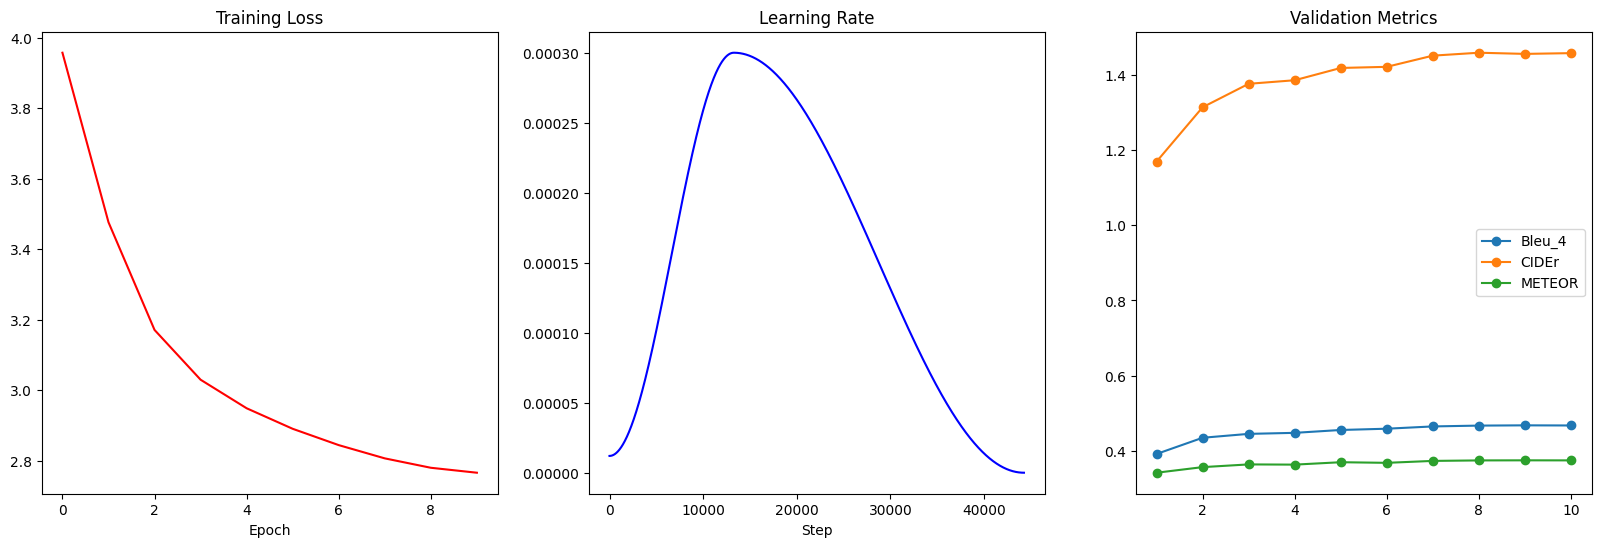

In [ ]:


# --- Cấu hình Huấn luyện ---


# Sử dụng PAD ID từ bộ Vocab (stoi) để ignore loss
CE = nn.CrossEntropyLoss(ignore_index=PAD, label_smoothing=0.1)
optim = torch.optim.AdamW(model.parameters(), lr=ONECYCLE_MAX_LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler('cuda') 

# Scheduler OneCycle giúp hội tụ nhanh và ổn định
sched = torch.optim.lr_scheduler.OneCycleLR(
    optim,
    max_lr=ONECYCLE_MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=len(train_dl),
)

train_loss_hist = []
metric_hist = {'Bleu_4': [], 'CIDEr': [], 'METEOR': []}
lr_hist = []

best_cider = 0.0
best_path = OUT_DIR / "butd_vietnamese_best.pt"

# --- Vòng lặp Huấn luyện ---
for ep in range(1, EPOCHS + 1):
    model.train()
    running_loss, total_tok = 0.0, 0
    pbar = tqdm(train_dl, desc=f'BUTD Train ep{ep}/{EPOCHS}')
    
    for feats, tgt, lens in pbar:
        # Chuyển dữ liệu lên GPU
        feats = feats.to(DEVICE) # [Batch, Num_Regions, Feat_Dim]
        tgt = tgt.to(DEVICE)     # [Batch, Seq_Len]
        
        # Teacher Forcing logic: 
        # Input (inp): <s> từ_1 ... từ_n-1
        # Target (tar): từ_1 ... từ_n </s>
        inp = tgt[:, :-1]
        tar = tgt[:, 1:]
        
        optim.zero_grad(set_to_none=True)
        
        # Mixed Precision (FP16)
        with autocast(device_type='cuda'):
            # Model BUTD trả về logits dựa trên đặc trưng ảnh và input text
            logits = model(feats, inp)
            
            # Đảm bảo logits và tar khớp kích thước (phòng trường hợp max_len cắt tỉa)
            min_t = min(logits.size(1), tar.size(1))
            logits_flat = logits[:, :min_t, :].reshape(-1, logits.size(-1))
            tar_flat = tar[:, :min_t].reshape(-1)
            
            loss = CE(logits_flat, tar_flat)
        
        # Backward với Scaler
        scaler.scale(loss).backward()
        
        # Gradient Clipping (Cực kỳ quan trọng cho LSTM để tránh vỡ loss)
        scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optim)
        scaler.update()
        sched.step()
        
        # Tính toán thống kê
        ntok = (tar_flat != PAD).sum().item()
        running_loss += float(loss.item()) * max(1, ntok)
        total_tok += max(1, ntok)
        
        curr_lr = optim.param_groups[0]['lr']
        lr_hist.append(curr_lr)
        pbar.set_postfix({
            'loss': f'{running_loss/max(1,total_tok):.4f}', 
            'lr': f'{curr_lr:.6f}'
        })

    avg_loss = running_loss / max(1, total_tok)
    train_loss_hist.append(avg_loss)
    print(f'Epoch {ep} | Train Loss: {avg_loss:.4f}')

    # ---------- Giai đoạn Evaluation ----------
    if ep % N_EVAL == 0 or ep == EPOCHS:
        print(f"--- Đang đánh giá tại Epoch {ep} ---")
        
        # 1. Dự đoán (Beam Search)
        res_json = OUT_DIR / f"res_ep{ep}.json"
        # Hàm predict_from_loader cần được định nghĩa để dùng Beam Search của model
        predict_from_loader(val_img_dl, res_json, beam=5, lp=0.7, ngram=2)
        
        # 2. Tính Metrics
        try:
            metrics = coco_eval(VAL_JSON, res_json, title=f'Epoch {ep} Validation')
            
            # Lưu lịch sử
            for k in metric_hist.keys():
                if k in metrics:
                    metric_hist[k].append(metrics[k])
            
            # Lưu Checkpoint tốt nhất dựa trên CIDEr
            current_cider = metrics.get('CIDEr', 0)
            if current_cider > best_cider:
                best_cider = current_cider
                torch.save({
                    'model': model.state_dict(),
                    'stoi': stoi,
                    'itos': itos,
                    'epoch': ep,
                    'best_cider': best_cider
                }, best_path)
                print(f'✓ Checkpoint Saved! Best CIDEr: {best_cider:.4f}')
        except Exception as e:
            print(f"⚠️ Lỗi Eval: {e}")

# ---------- Vẽ đồ thị (Monitoring) ----------
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.plot(train_loss_hist, color='red'); plt.title('Training Loss'); plt.xlabel('Epoch')
plt.subplot(1, 3, 2)
plt.plot(lr_hist, color='blue'); plt.title('Learning Rate'); plt.xlabel('Step')
plt.subplot(1, 3, 3)
eval_epochs = [i*N_EVAL for i in range(1, len(metric_hist['CIDEr']) + 1)]
for k, v in metric_hist.items():
    plt.plot(eval_epochs, v, label=k, marker='o')
plt.title('Validation Metrics'); plt.legend(); plt.show()